In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
!pip install keras-tuner --upgrade
import pandas as pd
import numpy as np
import os
from numpy import concatenate
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalizationV2, TimeDistributed, RepeatVector, Reshape,BatchNormalization,Activation,Flatten,Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch, Hyperband, gridsearch
from keras.utils.vis_utils import plot_model
from datetime import date, datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.optimizers import Adam, RMSprop, Adagrad,SGD
from statsmodels.tsa.stattools import adfuller

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.8 MB/s eta 0:00:00


In [5]:
def first_prep(data_path):
  data=pd.read_csv(data_path)
  data["Time(year-month-day h:m:s)"] = pd.to_datetime(data["Time(year-month-day h:m:s)"])
  data= data.sort_values(by='Time(year-month-day h:m:s)', ascending=True)
  data.set_index('Time(year-month-day h:m:s)', inplace=True)
  return data

In [6]:
solar_data=first_prep('/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/Solar-station-site-1-_Nominal-capacity-50MW_.csv')
wind_data=first_prep('/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/Wind-farm-site-1-_Nominal-capacity-99MW_-_1_.csv')

**Approche univariée**





In [7]:
Solar_Power=solar_data[['Power (MW)']].copy()
Wind_Power=wind_data[['Power (MW)']].copy()

#Split the data into train and test for solar data
train_S=Solar_Power[:int(len(solar_data)*0.8)]
test_S=Solar_Power[int(len(solar_data)*0.8):]
#Split the data into train and test
train_W=Wind_Power[:int(len(wind_data)*0.8)]
test_W=Wind_Power[int(len(wind_data)*0.8):]

def Scaler(train,test):
 sc1=StandardScaler()
 sc2=StandardScaler()
 train_scaled=sc1.fit_transform(train)
 test_scaled=sc2.fit_transform(test)
 return train_scaled,test_scaled,sc1,sc2

train_S,test_S,sc_train_S,sc_test_S=Scaler(train_S,test_S)
train_W,test_W,sc_train_W,sc_test_W=Scaler(train_W,test_W)

#split to sequence for determine the step_inputs and the step_outputs

def split_sequences(df,step_in=960,step_out=24):
 X,y=[],[]
 for i in range(step_in,len(df)-step_out):
  X.append(df[i-step_in:i])
  y.append(df[i:i+step_out])
 X=np.array(X)
 y=np.array(y)
 return X,y

X_train_S,y_train_S=split_sequences(train_S,step_in=96,step_out=24)
X_test_S,y_test_S=split_sequences(test_S,step_in=96,step_out=24)
X_train_W,y_train_W=split_sequences(train_W,step_in=96,step_out=24)
X_test_W,y_test_W=split_sequences(test_W,step_in=96,step_out=24)

def get_best_model(X_train,y_train,max_trials=10,executions_per_trial=1,project_name='univariate_Forecasting_CNNLSTM'):

  def CNNLSTM_model(hp):

   model=Sequential()
   model.add(Conv1D(hp.Int('filter_1',16,64,16),hp.Int('kernel_size_1',1,3,1),activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
   model.add(MaxPooling1D(hp.Int('pool_size',1,3,1)))
   model.add(Conv1D(hp.Int('filter_2',16,64,16),hp.Int('kernel_size_2',1,3,1)))
   model.add(MaxPooling1D(hp.Int('pool_size',1,3,1)))
   model.add(CuDNNLSTM(hp.Int('unit_1',50,150,50),return_sequences=True))
   model.add(Activation('relu'))
   model.add(CuDNNLSTM(hp.Int('unit_2',50,150,50)))
   model.add(Dense(y_train_S.shape[1]))
   batch_size_=hp.Int('batch_size',32,64,16)
   epochs=hp.Int('epochs',5,20,5)
   model.compile(optimizer='adam',loss='mae',metrics=['mae','mse'])

   return model


  tuner = RandomSearch(CNNLSTM_model, max_trials=max_trials, objective='mse', executions_per_trial=executions_per_trial, directory='solar_wind_power_forecasting', project_name=project_name)
  es = EarlyStopping(monitor='mse', patience=5, mode='min', verbose=1, restore_best_weights = True)
  cp = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, save_weights_only=True, monitor='mse', mode='min', verbose=1)
  tuner.search(X_train, y_train, verbose=1,batch_size=32,validation_split=0.2,callbacks=[cp,es],shuffle=False)
  #Get the best_hyperpameters
  best_hyp = tuner.get_best_hyperparameters()[0]
  model = tuner.hypermodel.build(best_hyp)
  model_summary=model.summary()
  history = model.fit(X_train, y_train, validation_split=0.2, epochs=best_hyp.get('epochs'), batch_size=best_hyp.get('batch_size'), callbacks=[cp,es], verbose=1,shuffle=False)
  #model_trained= tuner.get_best_models(num_models=1)[0]

  return history,model,model_summary

In [8]:
import tensorflow as tf
def save_model(model,model_path):
  if os.path.exists(model_path):
    os.remove(model_path)
    print(f"Deleted existing model: {model_path}")
    model.save(model_path)
  else:
    print(f"No existing model found at: {model_path}")
    model.save(model_path)

def load_model(model_path):
  loaded_model = tf.keras.models.load_model(model_path)
  return loaded_model

In [9]:
def history_model(model):
    plt.figure(1)
    plt.plot(model.history['mae'])
    plt.plot(model.history['val_mae'])
    plt.title('mae & val_mae')
    plt.legend(['mae', 'val_mae'])
    plt.show()

    plt.figure(2)
    plt.plot(model.history['mse'])
    plt.plot(model.history['val_mse'])
    plt.title('mse & val_mse')
    plt.legend(['mse', 'val_mse'])
    plt.show()

In [ ]:
history_u_CNNLSTM_S,model_u_CNNLSTM_S,model_summary=get_best_model(X_train_S,y_train_S,project_name='solar power foreacasting_unvariate_CNNLSTM_1')
model_summary

Trial 10 Complete [00h 00m 23s]
mse: 0.27482515573501587

Best mse So Far: 0.2431330382823944
Total elapsed time: 00h 04m 12s
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 96, 48)            96        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 96, 48)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 95, 64)            6208      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 95, 64)           0         
 1D)                                                             
                                                                 
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 95, 100)           66400

In [ ]:
#save model_u_LSTM_S
save_model(model_u_CNNLSTM_S,'/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_u_CNNLSTM_S.h5')

Deleted existing model: /content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_u_CNNLSTM_S.h5


In [ ]:
#load model
model_u_CNNLSTM_S=load_model('/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_u_CNNLSTM_S.h5')

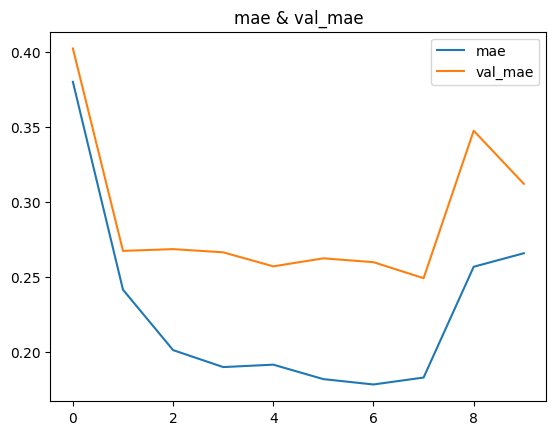

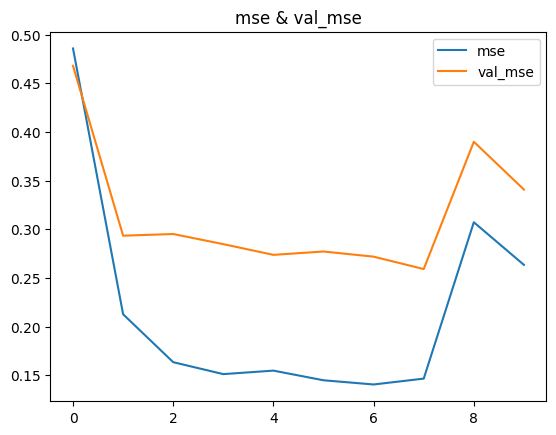

In [ ]:
history_model(history_u_CNNLSTM_S)

In [25]:
def evalute_model(model,data,train,scaler,X_test,y_test,start,step_in,n_forecast,color_d):
 predictions=model.predict(X_test)
 predictions=scaler.inverse_transform(predictions)
 y_test=y_test.reshape(y_test.shape[0],y_test.shape[1])
 y_test=scaler.inverse_transform(y_test)
 for i in range(len(y_test)-1):
  bias=abs(y_test[i,1]-predictions[i,1])
  predictions[i,1]=y_test[i,1]-bias
 print(bias)
###############################
 plt.figure(figsize=(10,5))
 plt.plot(data.index[len(train)+start:len(train)+start+step_in+1],y_test[start:start+step_in+1,1],color=color_d)
 plt.plot(data.index[len(train)+start+step_in:len(train)+start+step_in+n_forecast],y_test[start+step_in:start+step_in+n_forecast,1],label='Valeures Réels',color='green')
 plt.plot(data.index[len(train)+step_in+start:len(train)+n_forecast+start+step_in],predictions[start+step_in:start+step_in+n_forecast,1],linestyle='dashed',color='red',label='Prévision parCNN-LSTM')
 plt.xlabel('Temps')
 plt.ylabel('Energie en (MW)')
 plt.legend()
 plt.title('Valeurs prévisionnelles vs Valeurs réelles')
 mae=mean_absolute_error(y_test,predictions)
 mse=mean_squared_error(y_test,predictions)
 rmse = np.sqrt(mse)
 mape = mean_absolute_percentage_error(y_test,predictions)
 print('mae=',mae)
 print('mse=',mse)
 print('rmse=',rmse)
 print('mape=',mape)


 return predictions

435/435 [==============================] - 2s 5ms/step
7.701395874023437
mae= 5.087388528369215
mse= 83.15838406520105
rmse= 9.119121891125321
mape= 6000405163091009.0


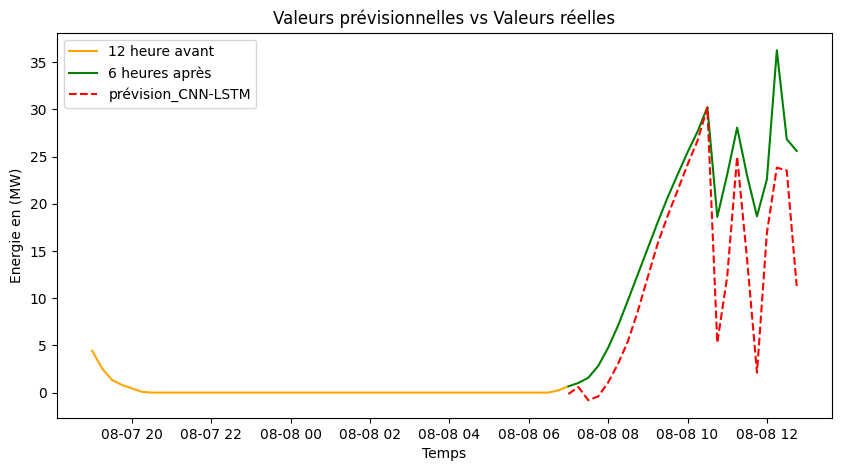

In [ ]:
predictions_u_CNNLSTM_S=evalute_model(model_u_CNNLSTM_S,solar_data,train_S,sc_test_S,X_test_S,y_test_S,0,48,24,'orange')

In [ ]:
history_u_CNNLSTM_W,model_u_CNNLSTM_W,model_summary=get_best_model(X_train_W,y_train_W,project_name='Wind power foreacasting_unvariate_CNNLSTM')
model_summary

Trial 10 Complete [00h 00m 23s]
mse: 0.4700564742088318

Best mse So Far: 0.4700564742088318
Total elapsed time: 00h 03m 23s
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 95, 48)            144       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 95, 48)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 94, 64)            6208      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 94, 64)           0         
 1D)                                                             
                                                                 
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 94, 50)            23200 

In [ ]:
#save model_u_LSTM_W
save_model(model_u_LSTM_W,'/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_u_CNNLSTM_W.h5')

No existing model found at: /content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_u_CNNLSTM_W.h5


In [ ]:
#load model
model_u_CNNLSTM_W=load_model('/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_u_CNNLSTM_W.h5')

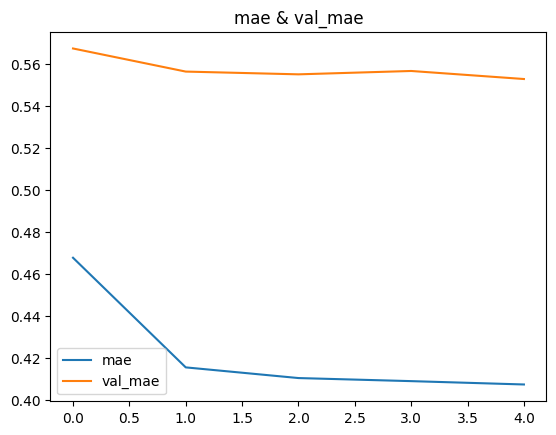

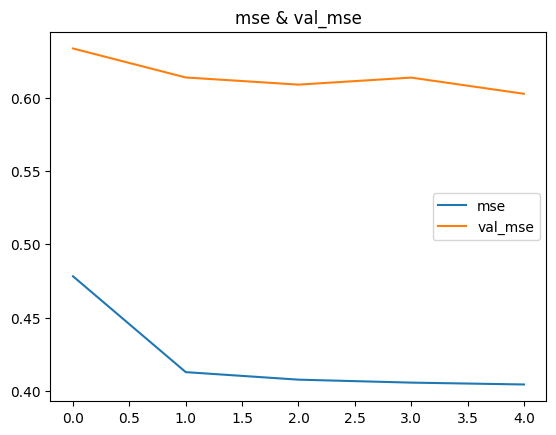

In [ ]:
history_model(history_u_CNNLSTM_W)

435/435 [==============================] - 2s 5ms/step
0.9217708349227891
mae= 10.17747360343718
mse= 266.9550250387529
rmse= 16.338758368944468
mape= 195505007794333.84


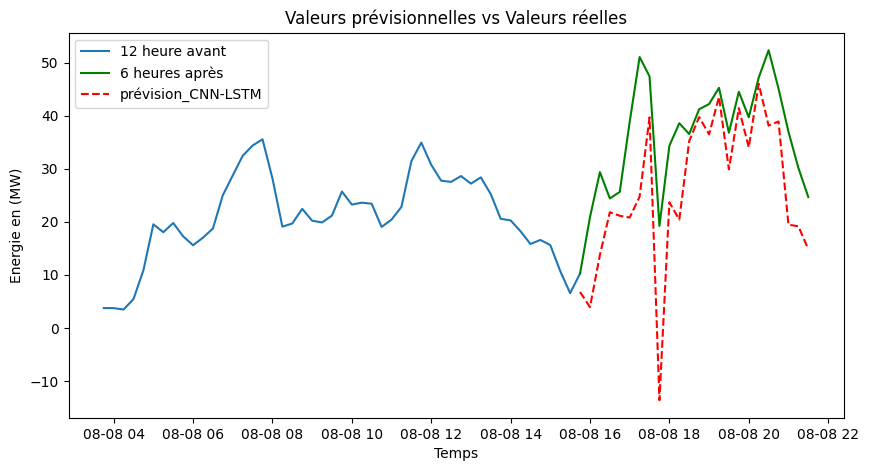

In [ ]:
predictions_u_CNNLSTM_W=evalute_model(model_u_CNNLSTM_W,wind_data,train_W,sc_test_W,X_test_W,y_test_W,35,48,24,None)

**Approche multivariée**

In [11]:
solar_data=first_prep('/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/Solar-station-site-1-_Nominal-capacity-50MW_.csv')
wind_data=first_prep('/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/Wind-farm-site-1-_Nominal-capacity-99MW_-_1_.csv')

In [12]:
def filter_features_by_correlation(df, label_name):
    # Calculer la matrice de corrélation entre les features et le label
    correlation_matrix = df.corr()

    # Sélectionner la colonne de corrélation avec le label
    label_correlation = correlation_matrix[label_name]
    correlation_threshold = abs(label_correlation).mean()


    # Filtrer les features dont le coefficient de corrélation avec le label dépasse la valeur seuil
    correlated_features = label_correlation[abs(label_correlation) > correlation_threshold].index.tolist()
    data=df[correlated_features]

    return data

In [13]:
solar_data_correlated=filter_features_by_correlation(solar_data,'Power (MW)')

In [ ]:
solar_data_correlated

,Total solar irradiance (W/m2),Direct normal irradiance (W/m2),Global horizontal irradiance (W/m2),Power (MW)
Time(year-month-day h:m:s),,,,
2019-01-01 00:00:00,0,0,0,0.0
2019-01-01 00:15:00,0,0,0,0.0
2019-01-01 00:30:00,0,0,0,0.0
2019-01-01 00:45:00,0,0,0,0.0
2019-01-01 01:00:00,0,0,0,0.0
...,...,...,...,...
2020-12-31 22:45:00,0,1,0,0.0
2020-12-31 23:00:00,0,1,0,0.0
2020-12-31 23:15:00,0,1,0,0.0


In [14]:
wind_data_correlated=filter_features_by_correlation(wind_data,'Power (MW)')

In [ ]:
type(wind_data_correlated)

In [15]:
#Split the data into train and test for solar data
train_S_m=solar_data_correlated[:int(len(solar_data)*0.8)]
test_S_m=solar_data_correlated[int(len(solar_data)*0.8):]
#Split the data into train and test
train_W_m=wind_data_correlated[:int(len(wind_data)*0.8)]
test_W_m=wind_data_correlated[int(len(wind_data)*0.8):]

In [ ]:
train_S_m.shape

(56140, 4)

In [16]:
#split to features and label
def split_features_label(data,label):
  label=data[[label]].copy()
  features=data.drop(label,axis=1)
  scaler=StandardScaler()
  features=scaler.fit_transform(features)
  label=scaler.fit_transform(label)
  return features,label,scaler

In [17]:
train_features_S,train_label_S,scaler_train_s=split_features_label(train_S_m,'Power (MW)')
test_features_S,test_label_S,scaler_test_s=split_features_label(test_S_m,'Power (MW)')

train_features_W,train_label_W,scaler_train_w=split_features_label(train_W_m,'Power (MW)')
test_features_W,test_label_W,scaler_test_w=split_features_label(test_W_m,'Power (MW)')

In [18]:
def split_sequences_2(features,label,step_in=960,step_out=12):
 X,y=[],[]
 for i in range(step_in,len(features)-step_out):
  X.append(features[i-step_in:i])
  y.append(label[i:i+step_out])
 X=np.array(X)
 y=np.array(y)
 return X,y

X_train_S,y_train_S=split_sequences_2(train_features_S,train_label_S,step_in=96,step_out=24)
X_test_S,y_test_S=split_sequences_2(test_features_S,test_label_S,step_in=96,step_out=24)


X_train_W,y_train_W=split_sequences_2(train_features_W,train_label_W,step_in=96,step_out=24)
X_test_W,y_test_W=split_sequences_2(test_features_W,test_label_W,step_in=96,step_out=24)

In [ ]:
history_m_CNNLSTM_S,model_m_CNNLSTM_S,model_summary=get_best_model(X_train_S,y_train_S,project_name='solar power foreacasting_multivariat_CNNLSTM_1')
model_summary

Trial 10 Complete [00h 00m 23s]
mse: 0.3183920979499817

Best mse So Far: 0.2570611238479614
Total elapsed time: 00h 03m 25s
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 94, 32)            320       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 31, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 31, 64)            2112      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 10, 64)           0         
 1D)                                                             
                                                                 
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 10, 100)           66400 

In [ ]:
#save model_u_LSTM_S
save_model(model_m_CNNLSTM_S,'/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_m_CNNLSTM_S.h5')

No existing model found at: /content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_m_CNNLSTM_S.h5


In [19]:
#load model
model_m_CNNLSTM_S=load_model('/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_m_CNNLSTM_S.h5')

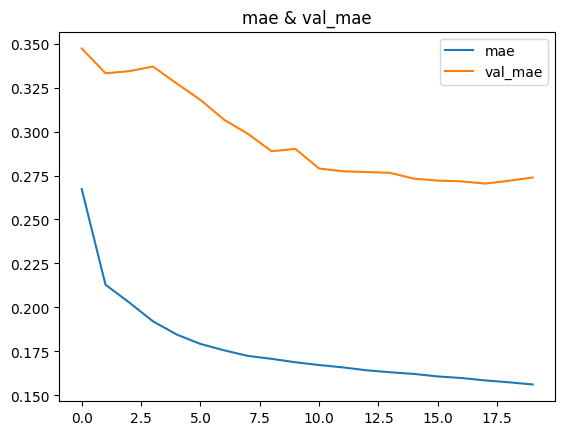

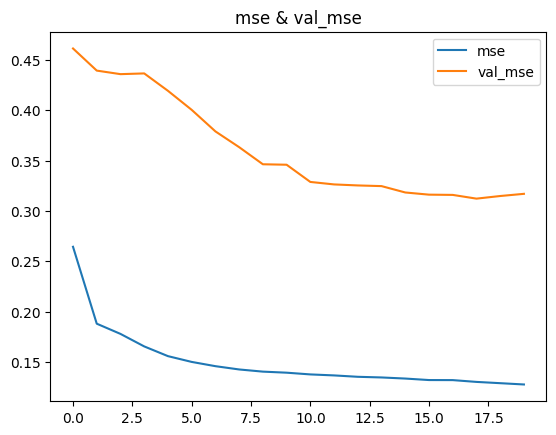

In [ ]:
history_model(history_m_CNNLSTM_S)

436/436 [==============================] - 1s 3ms/step
0.2709873914718628
mae= 3.0026606638036077
mse= 39.42339155051347
rmse= 6.278804946047733
mape= 1148587953748033.2


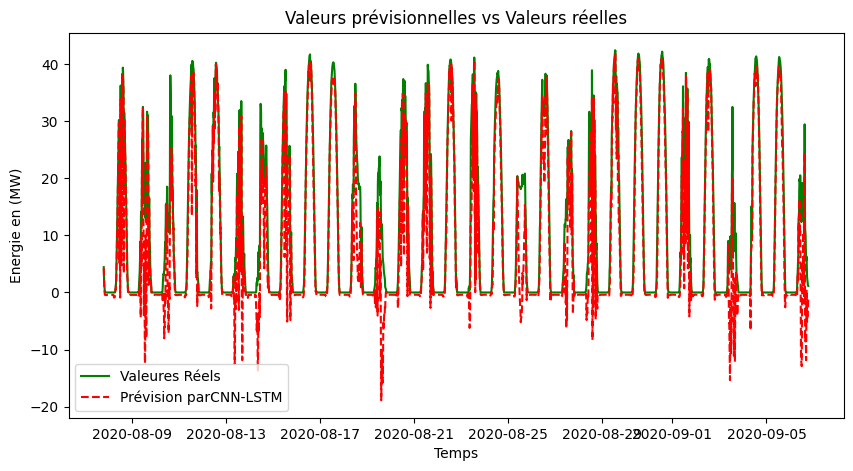

In [26]:
predictions_m_CNNLSTM_S=evalute_model(model_m_CNNLSTM_S,solar_data,train_S,sc_test_S,X_test_S,y_test_S,0,0,2880,'orange')

In [ ]:
history_m_CNNLSTM_W,model_m_CNNLSTM_W,model_summary=get_best_model(X_train_W,y_train_W,project_name='Wind power foreacasting_multivariat_CNNLSTM')
model_summary

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 94, 32)            416       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 94, 32)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 92, 48)            4656      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 92, 48)           0         
 1D)                                                             
                                                                 
 cu_dnnlstm_4 (CuDNNLSTM)    (None, 92, 100)           60000     
                                                                 
 activation_2 (Activation)   (None, 92, 100)          

In [ ]:
#save model_u_LSTM_W
save_model(model_m_CNNLSTM_W,'/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_m_CNNLSTM_W.h5')

Deleted existing model: /content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_m_CNNLSTM_W.h5


In [23]:
#load model
model_m_CNNLSTM_W=load_model('/content/drive/MyDrive/PV-Wind_Forecasting_Hmidani-Hicham/model_m_CNNLSTM_W.h5')

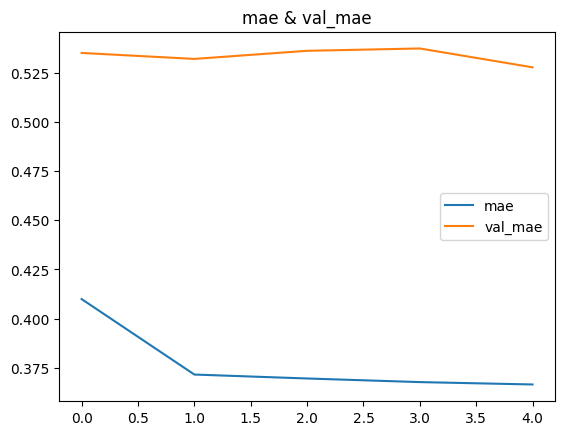

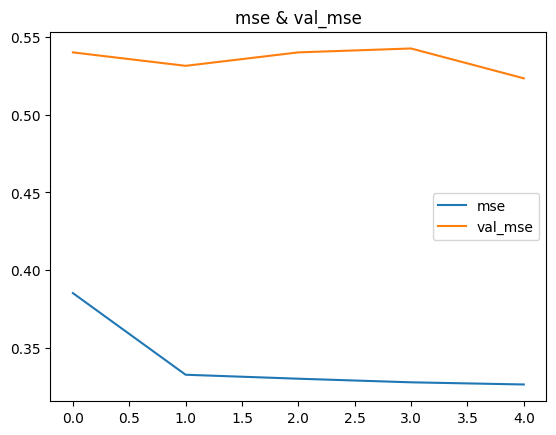

In [ ]:
history_model(history_m_CNNLSTM_W)

436/436 [==============================] - 2s 6ms/step
25.406636176109313
mae= 10.621654459149779
mse= 266.5926539355681
rmse= 16.32766529346949
mape= 401396191163146.5


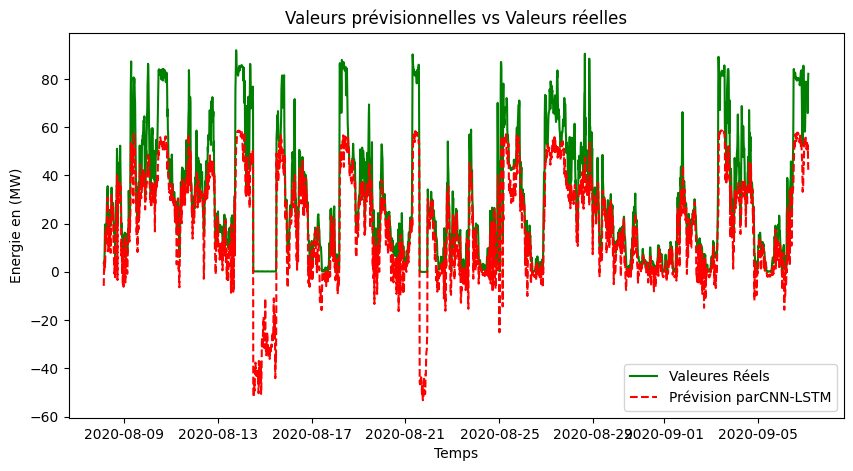

In [27]:
predictions_m_CNNLSTM_W=evalute_model(model_m_CNNLSTM_W,wind_data,train_W,sc_test_W,X_test_W,y_test_W,35,0,2880,None)

out of project

In [ ]:
# Forecasting Future Sales
# Assuming 'your_dataframe' contains all the data, not just the training set
X_future = your_dataframe['sales'][-n_steps:].values.reshape(1, n_steps, 1)
future_forecast = []
for i in range(n):  # Replace 'n' with the number of future steps to forecast
    y_pred = model.predict(X_future)
    future_forecast.append(y_pred[0, 0])
    X_future = np.append(X_future[:, 1:, :], y_pred, axis=1)

In [ ]:
from statsmodels.tsa.seasonal import STL

# Example time series data
# Replace this with your own time series data (e.g., load from a CSV or Excel file)
data = pd.Series([40, 42, 43, 48, 50, 45, 44, 47, 50, 55, 60, 63, 62, 65, 70, 72, 75, 80, 82, 85])

# Perform seasonal decomposition using STL
stl = STL(data, seasonal=13)  # Set seasonal period (here, 13 observations per season)
result = stl.fit()

# Extract the trend, seasonal, and residual components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the original time series and its components
plt.figure(figsize=(10, 6))
plt.subplot(4, 1, 1)
plt.plot(data, label='Original Data')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()